In [2]:
# pip install xmltodict

In [266]:
# 농수축 & 이미용 EDAddd
# !pip install plotly
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from tqdm.notebook import tqdm
import requests
import xmltodict
import re
# pd.set_option('display.max_rows', 100)
%matplotlib inline
plt.style.use('ggplot') # 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.rcParams['font.family'] = 'Malgun Gothic'

In [267]:
# 나눔고딕코드 폰트 설치 (필요한사람만 돌리세요)
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# plt.rc('font', family='NanumBarunGothic')

In [268]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    from google.colab import drive
    drive.mount('/content/drive')
    sum_df = pd.read_csv('/content/drive/My Drive/빅데이터_콘테스트/sum_df.csv')

else:
    print('Not running on CoLab')
    sum_df = pd.read_csv('c:/bc/sum_df.csv')

Not running on CoLab


In [269]:
seasons = [4, 4, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4]
month_to_season = dict(zip(range(1,13), seasons))

sum_df['season'] = sum_df.MONTH.map(month_to_season)

In [270]:
sum_df['timeslot'] = pd.cut(sum_df.HOUR, bins = [0,8,11,14,17,20,23,26], \
                             labels = [1,2,3,4,5,6,7])

In [271]:
month = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

total = {}
for i in month:
    service_key = 'JJC5IlOjBjhMwMvARvd2a0D3jVjHuA3DDvF1NZ27DH4pbq5Y1bzUmA0zYt6BOvI562qNa8Z87PlDLZZjYHA3YA%3D%3D'
    service_key_decode = requests.utils.unquote(service_key)

    req_params = {'ServiceKey' : service_key_decode, 'solYear' : '2019', 'solMonth' : i}
    req_url = 'http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getHoliDeInfo'

    resp = requests.get(req_url, params =req_params)
    xml_data = resp.text
    dict_data = xmltodict.parse(xml_data)

    if dict_data ['response']['body']['items'] is not None:
        data = dict_data ['response']['body']['items']['item']

        total[i] =  data

month_1 = ['01', '03', '06', '08', '12']

공휴일 = []
for  mon in month:
    if mon in month_1 :
        date = total[mon]['locdate']
        holiday = total[mon]['isHoliday']
        공휴일.append(date)

month_2 = ['02', '05', '09', '10']
for mon in month:
    if mon in month_2 :
        len_mon = len(total[mon])
        for d in range(len_mon):
            date = total[mon][d]['locdate']
            holiday = total[mon][d]['isHoliday']
            공휴일.append(date)
            
공휴일 = pd.to_datetime(공휴일, format='%Y-%m-%d', errors='raise')

In [272]:
def holiday(date):  
    if date in 공휴일 :
        holi = 1
    else:
        holi = 0
    return holi

sum_df['공휴일'] = sum_df['YEAR_DAY'].map(lambda x : holiday(x))

def weekend(day_name):
    if day_name in ['Saturday', 'Sunday']:
        holiday =  1
    else :
        holiday = 0
    return holiday

sum_df['weekend'] = sum_df['DAY_NAME'].map(lambda x : weekend(x))

In [273]:
쉬는날 = []
weekend = sum_df['weekend']
holi = sum_df['공휴일']

for i in range(len(sum_df)):
    if weekend[i] == 1 or holi[i] == 1 :
        쉬는날.append(1)
    else:
        쉬는날.append(0)

In [274]:
del sum_df['weekend']
del sum_df['공휴일']
sum_df['holiday'] = 쉬는날

In [275]:
def df_split(group):
    return sum_df[sum_df['p_group']==group]

In [276]:
def sales_split(group):
    return pd.qcut(sum_df[sum_df['p_group']==group].sales, q=5,labels=[1,2,3,4,5]).to_frame().rename(columns={'sales':'sales_group'})

In [277]:
interested_group_list = ['농수축','건강기능','가구','침구']

for group in interested_group_list:
    for idx, value in zip(sales_split(group).index,sales_split(group).sales_group):
        sum_df.loc[idx,'sales_group'] = value

In [278]:
sum_df

,broadcast,exp_min,m_code,p_code,p_name,p_group,unit_price,total_price,sales,YEAR,...,DAY_NUM,p_group_code,new_code,no,sales_level,grade,season,timeslot,holiday,sales_group
0,2019-01-01 06:00:00,60.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,32696000.0,820.0,2019,...,2,0,13.0,0,b,4,4,1,1,NaN
1,2019-01-01 07:00:00,60.0,100305,200974,오모떼 레이스 파운데이션 브라,속옷,59000,47878000.0,812.0,2019,...,2,1,7.0,6,b,4,4,1,1,NaN
2,2019-01-01 08:00:00,60.0,100808,202377,CERINI by PAT 남성 소프트 기모 릴렉스팬츠,의류,59900,99736000.0,1665.0,2019,...,2,0,16.0,9,d,3,4,1,1,NaN
3,2019-01-01 09:00:00,60.0,100816,202404,보코 리버시블 무스탕,의류,79000,90973000.0,1151.0,2019,...,2,0,18.0,12,c,3,4,2,1,NaN
4,2019-01-01 10:00:00,60.0,100809,202395,CERINI by PAT 남성 풀패키지 기모니트 3종,의류,79900,259678000.0,3250.0,2019,...,2,0,17.0,15,e,2,4,2,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6963,2019-12-31 18:20:00,60.0,100356,201134,마르엘라로사티 에코무스탕1종,의류,79000,201322000.0,2548.0,2019,...,2,0,8745.0,38259,e,2,4,5,0,NaN
6964,2019-12-31 19:20:00,60.0,100594,201819,레스토닉 블루투스 LED 서랍 침대 슈퍼싱글,가구,599000,102360000.0,155.0,2019,...,2,10,8723.0,38262,a,3,4,5,0,2.0
6965,2019-12-31 20:20:00,60.0,100501,201516,무이자 국내제조 노비타 뉴스파 비데 무료설치,생활용품,219000,191710000.0,762.0,2019,...,2,6,8741.0,38271,b,2,4,5,0,NaN
6966,2019-12-31 21:20:00,60.0,100155,200556,일시불 LG전자 매직스페이스 냉장고,가전,1359000,222022000.0,157.0,2019,...,2,5,8725.0,38283,a,2,4,6,0,NaN


# 시간대별

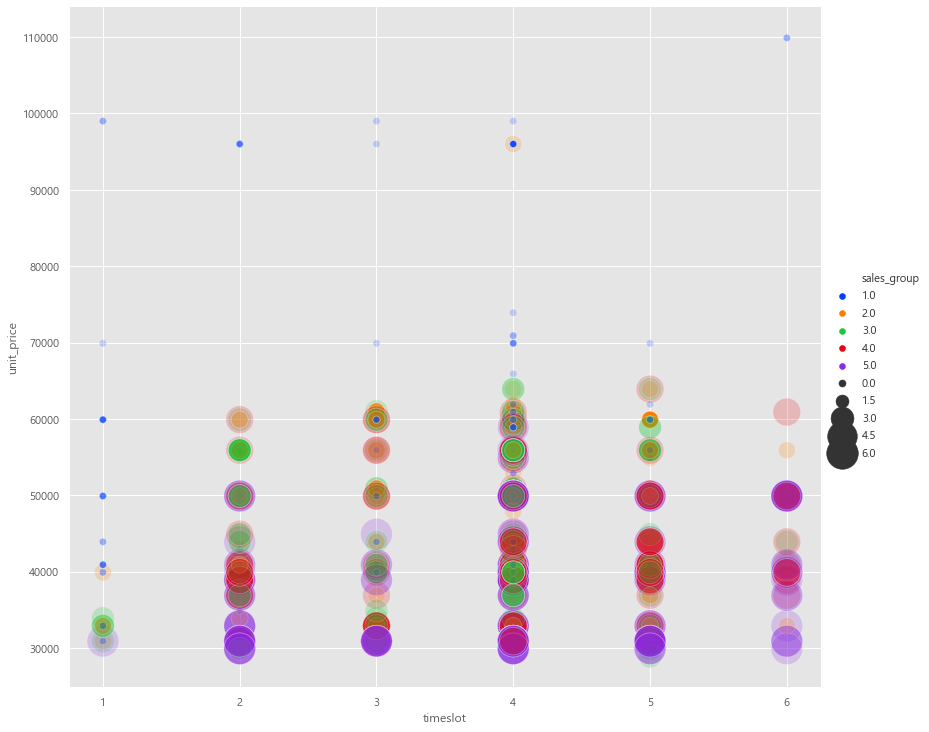

In [279]:
sns.relplot(x='timeslot',y='unit_price', palette='bright', size='sales_group', hue='sales_group', sizes=(50,1000), data=sum_df[sum_df['p_group']=='농수축'], alpha=0.2, height=10.27, aspect=11.7/10.27)

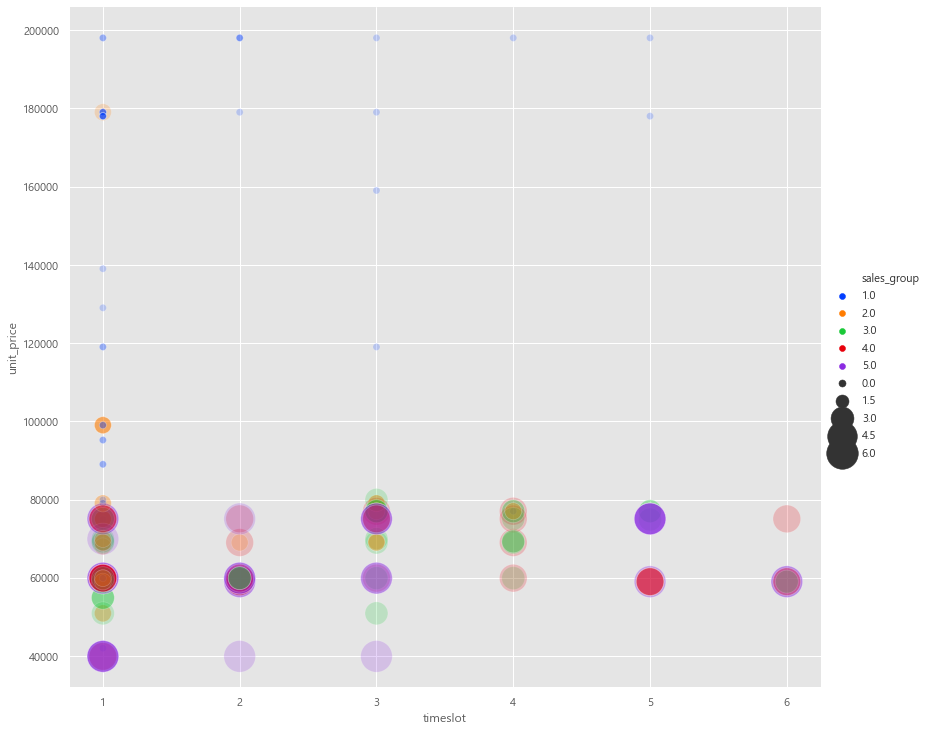

In [280]:
sns.relplot(x='timeslot',y='unit_price', palette='bright', size='sales_group', hue='sales_group', sizes=(50,1000), data=sum_df[sum_df['p_group']=='건강기능'], alpha=0.2, height=10.27, aspect=11.7/10.27)

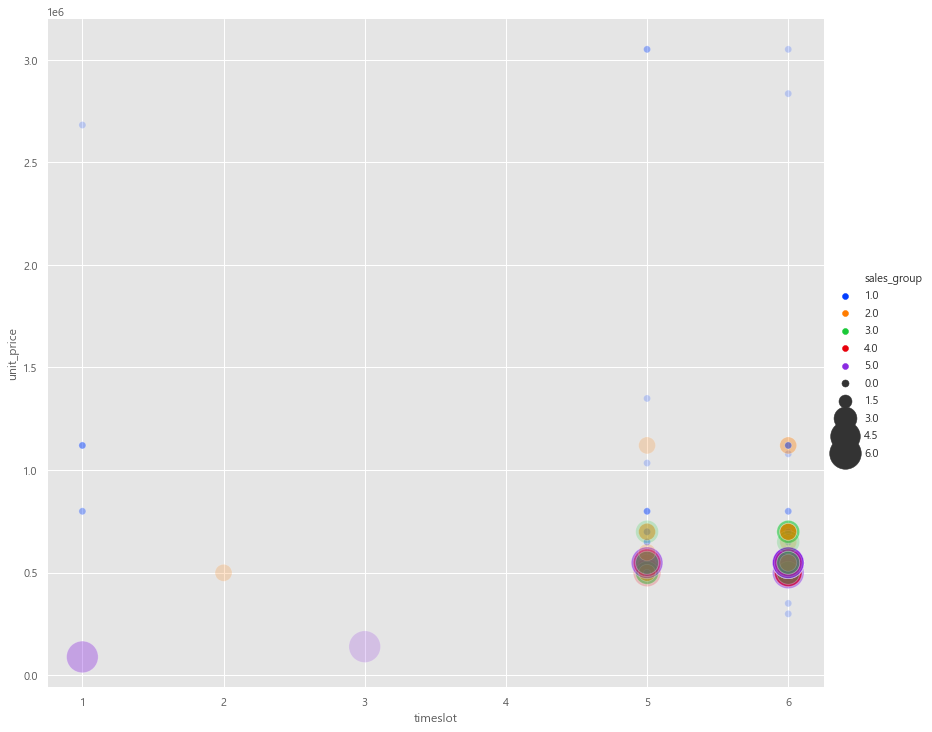

In [281]:
sns.relplot(x='timeslot',y='unit_price', palette='bright', size='sales_group', hue='sales_group', sizes=(50,1000), data=sum_df[sum_df['p_group']=='가구'], alpha=0.2, height=10.27, aspect=11.7/10.27)

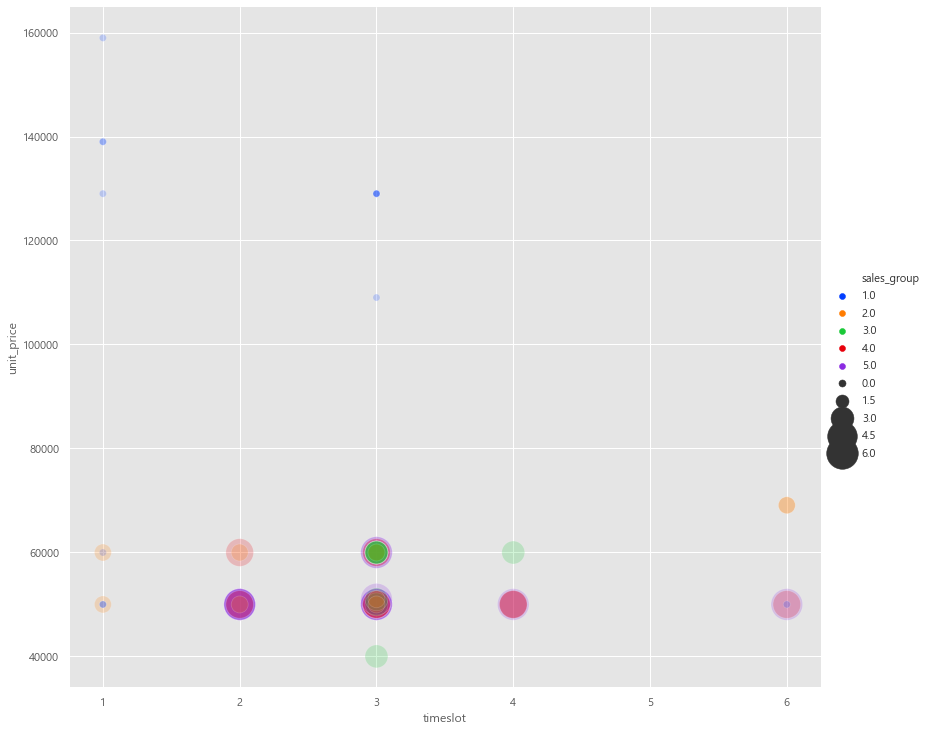

In [282]:
sns.relplot(x='timeslot',y='unit_price', palette='bright', size='sales_group', hue='sales_group', sizes=(50,1000), data=sum_df[sum_df['p_group']=='침구'], alpha=0.2, height=10.27, aspect=11.7/10.27)

# 요일별

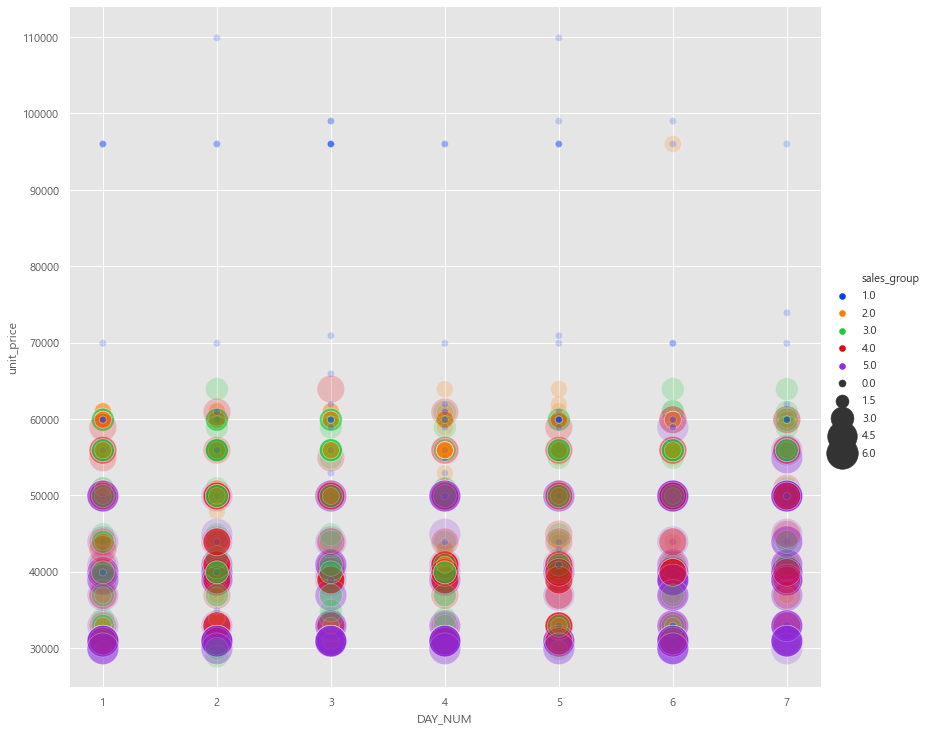

In [283]:
sns.relplot(x='DAY_NUM',y='unit_price', palette='bright', size='sales_group', hue='sales_group', sizes=(50,1000), data=sum_df[sum_df['p_group']=='농수축'], alpha=0.2, height=10.27, aspect=11.7/10.27)

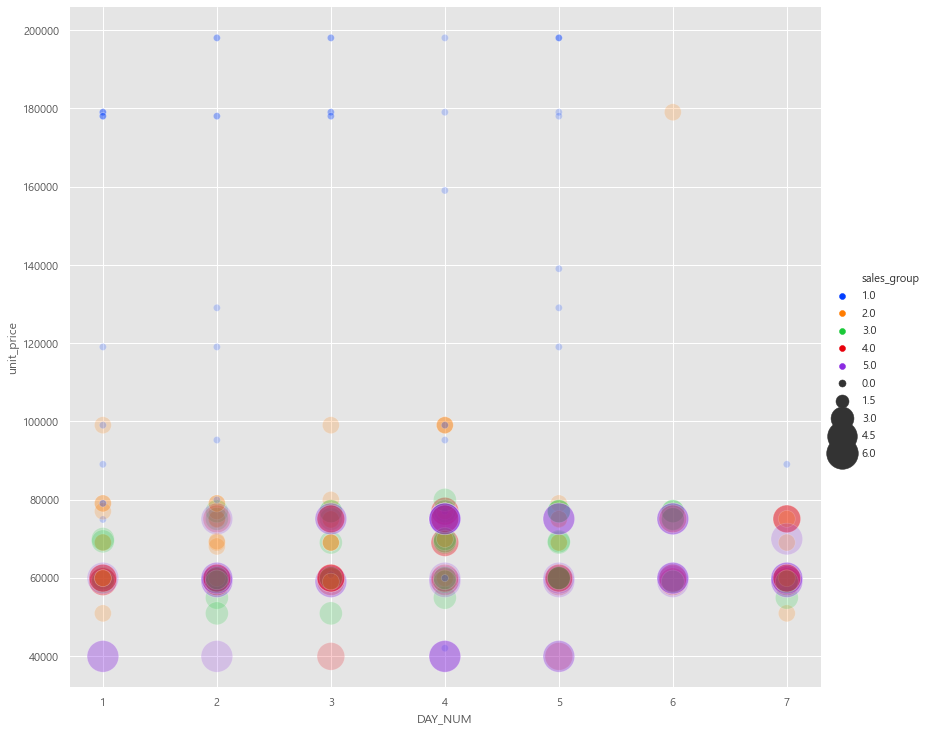

In [284]:
sns.relplot(x='DAY_NUM',y='unit_price', palette='bright', size='sales_group', hue='sales_group', sizes=(50,1000), data=sum_df[sum_df['p_group']=='건강기능'], alpha=0.2, height=10.27, aspect=11.7/10.27)

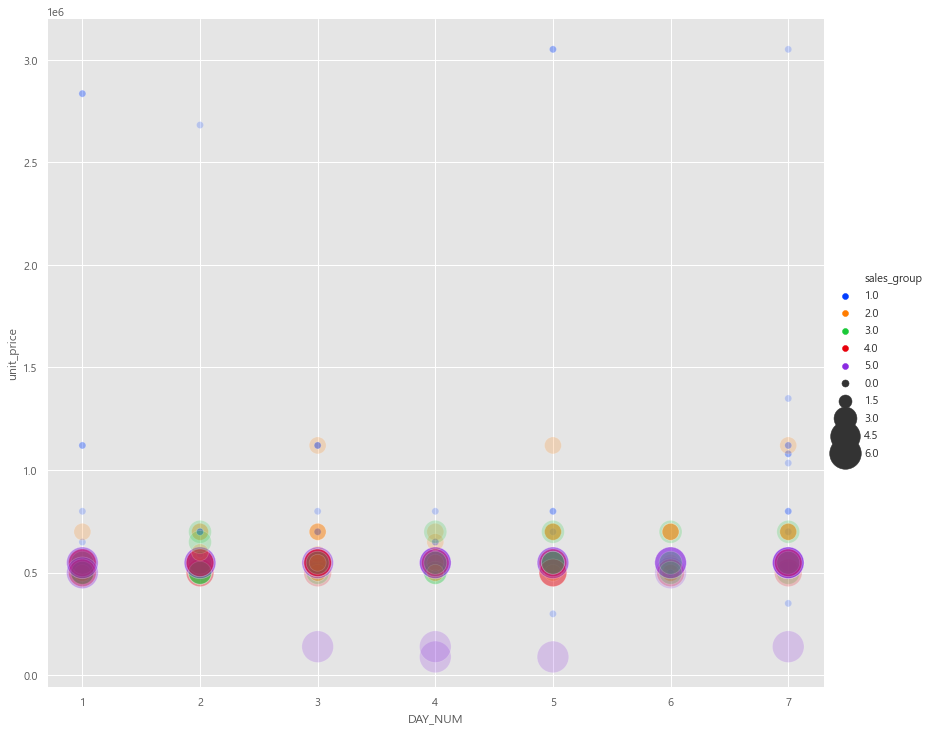

In [285]:
sns.relplot(x='DAY_NUM',y='unit_price', palette='bright', size='sales_group', hue='sales_group', sizes=(50,1000), data=sum_df[sum_df['p_group']=='가구'], alpha=0.2, height=10.27, aspect=11.7/10.27)

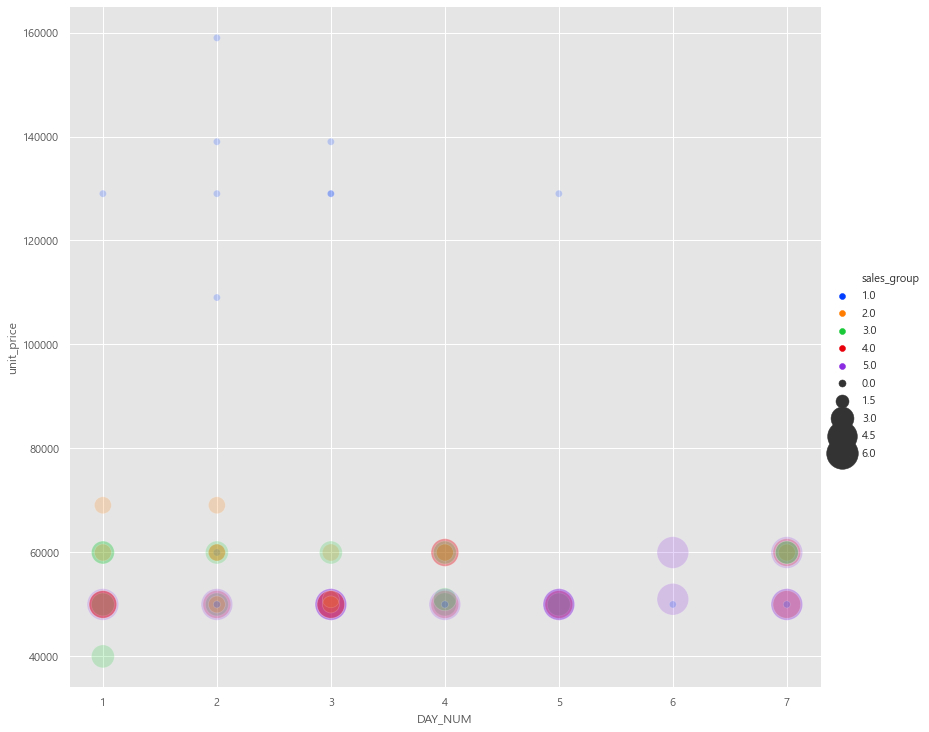

In [286]:
sns.relplot(x='DAY_NUM',y='unit_price', palette='bright', size='sales_group', hue='sales_group', sizes=(50,1000), data=sum_df[sum_df['p_group']=='침구'], alpha=0.2, height=10.27, aspect=11.7/10.27)

# 시즌별

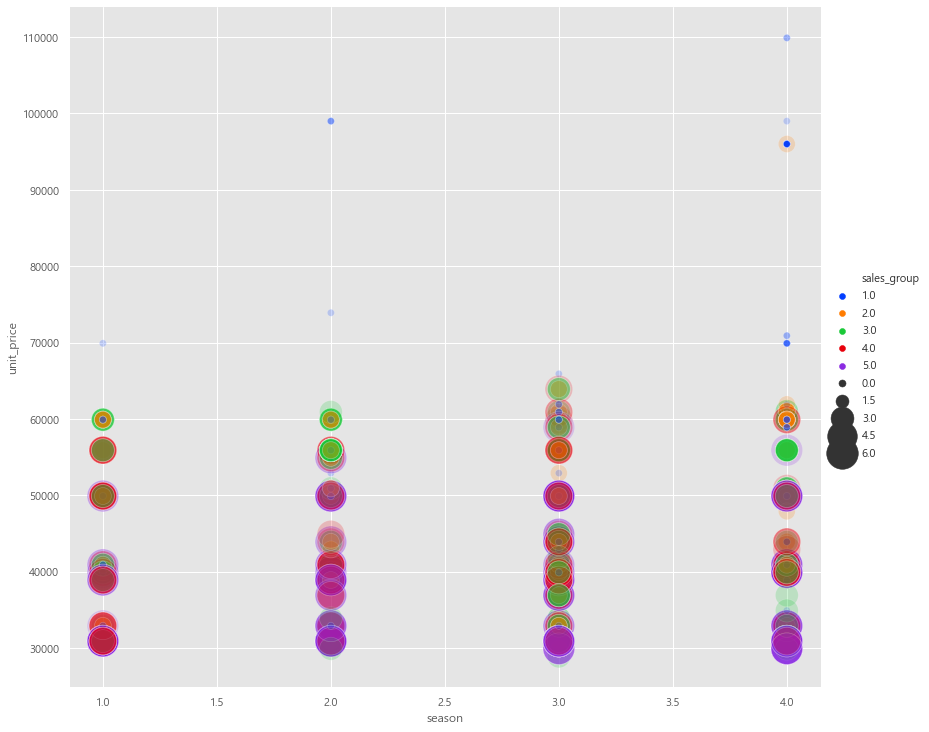

In [287]:
sns.relplot(x='season',y='unit_price', palette='bright', size='sales_group', hue='sales_group', sizes=(50,1000), data=sum_df[sum_df['p_group']=='농수축'], alpha=0.2, height=10.27, aspect=11.7/10.27)

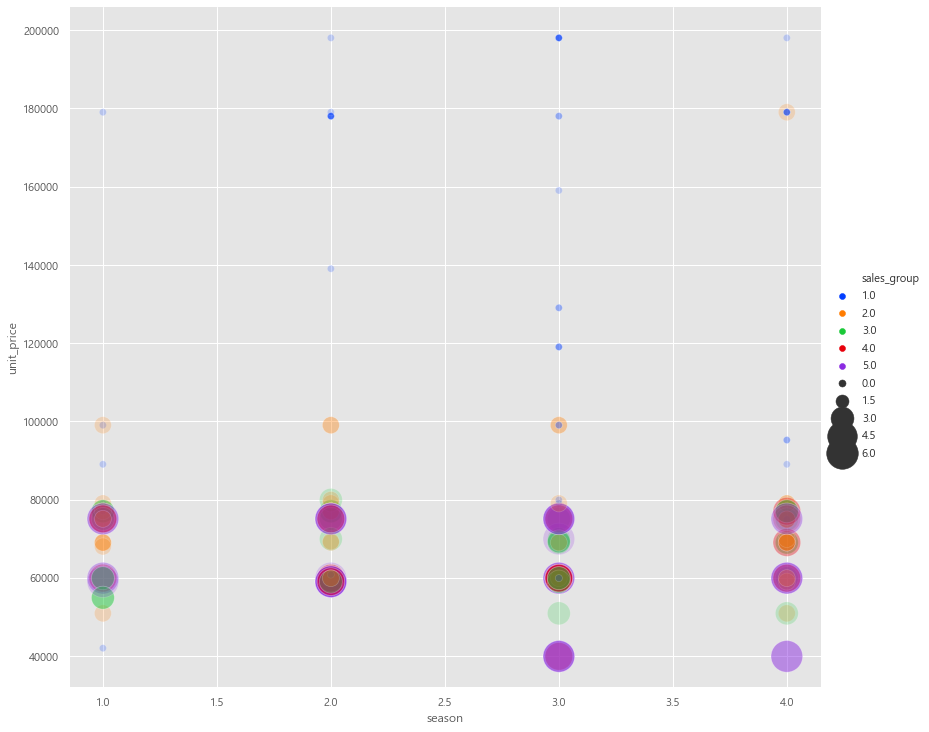

In [288]:
sns.relplot(x='season',y='unit_price', palette='bright', size='sales_group', hue='sales_group', sizes=(50,1000), data=sum_df[sum_df['p_group']=='건강기능'], alpha=0.2, height=10.27, aspect=11.7/10.27)

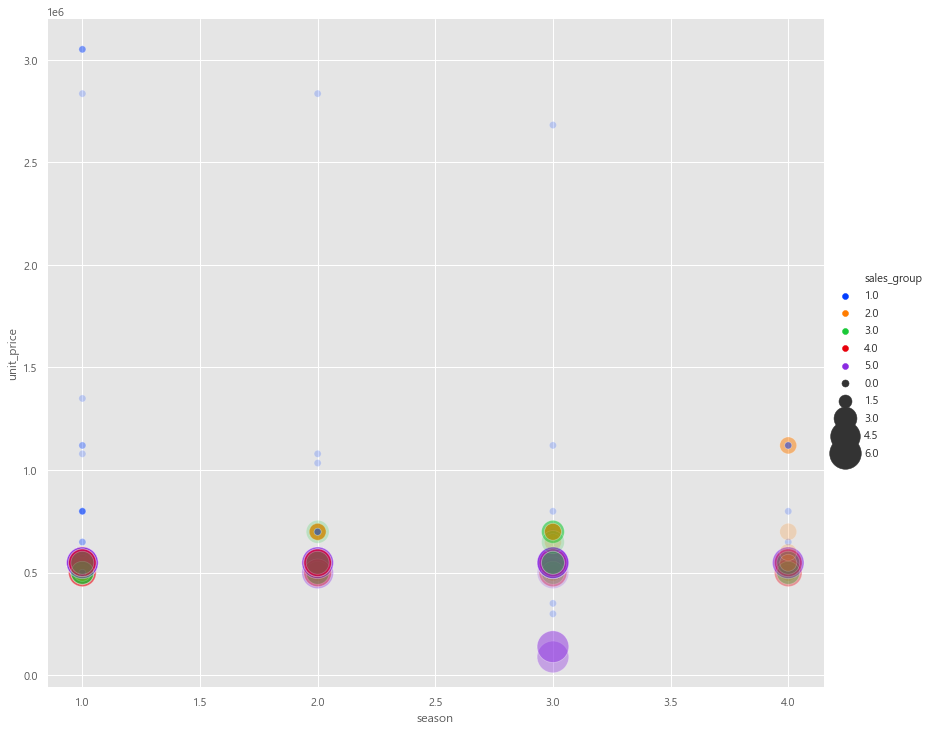

In [289]:
sns.relplot(x='season',y='unit_price', palette='bright', size='sales_group', hue='sales_group', sizes=(50,1000), data=sum_df[sum_df['p_group']=='가구'], alpha=0.2, height=10.27, aspect=11.7/10.27)

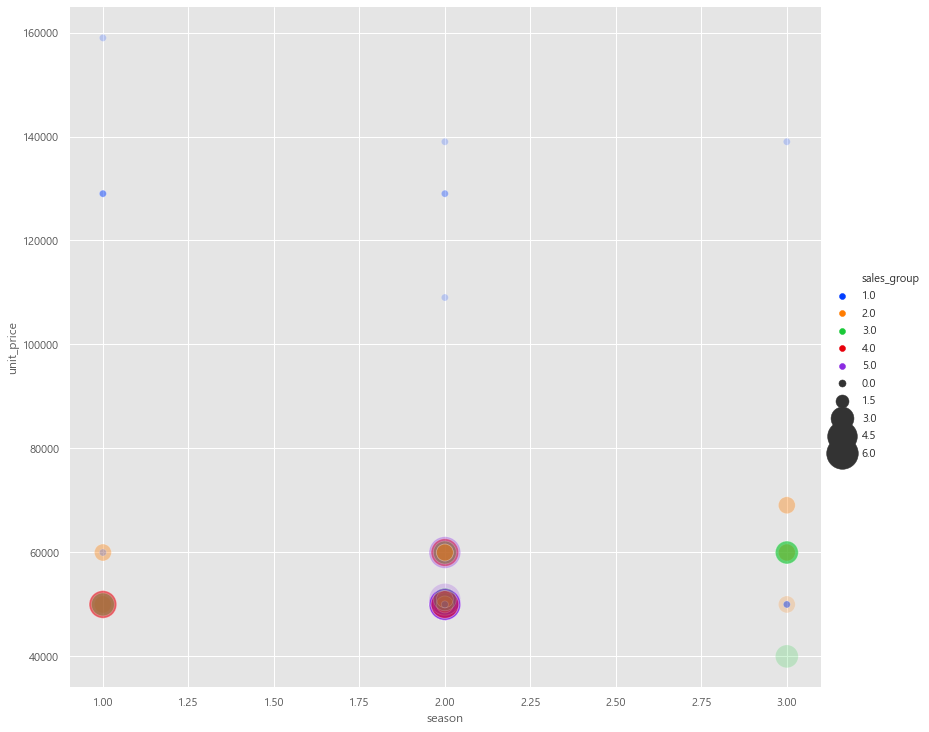

In [290]:
sns.relplot(x='season',y='unit_price', palette='bright', size='sales_group', hue='sales_group', sizes=(50,1000), data=sum_df[sum_df['p_group']=='침구'], alpha=0.2, height=10.27, aspect=11.7/10.27)

# 휴일 or 공휴일 ... 구분의 의미가 없어보인다. 통계적 검정 추가해보기?!

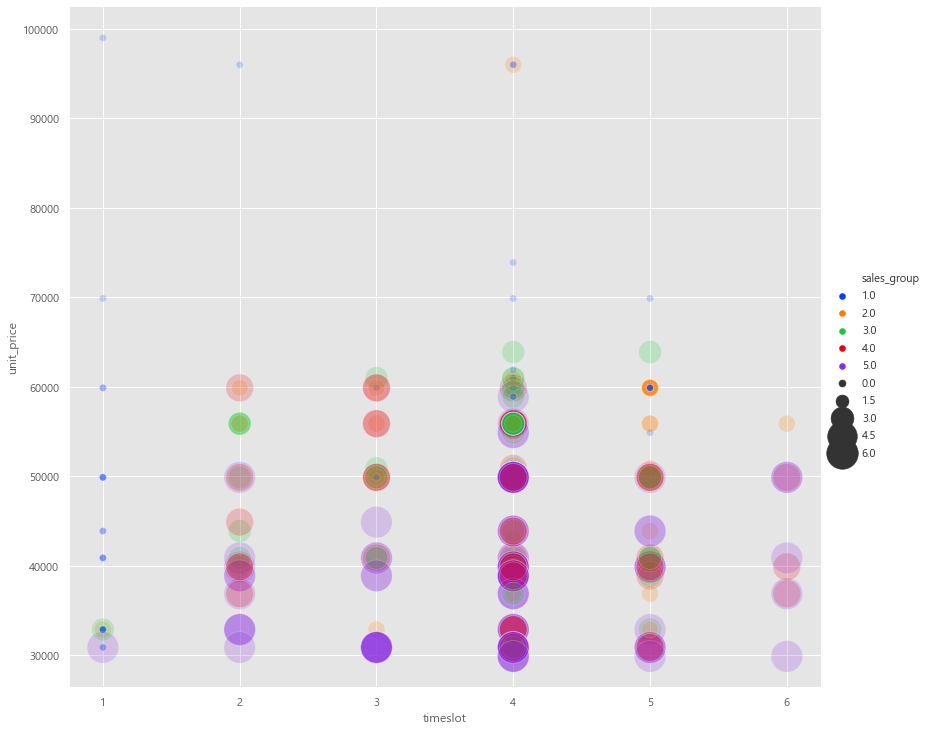

In [299]:
sns.relplot(x='timeslot',y='unit_price', palette='bright', size='sales_group', hue='sales_group', sizes=(50,1000), data=sum_df[(sum_df['p_group']=='농수축')&(sum_df['holiday']==1)], alpha=0.2, height=10.27, aspect=11.7/10.27)

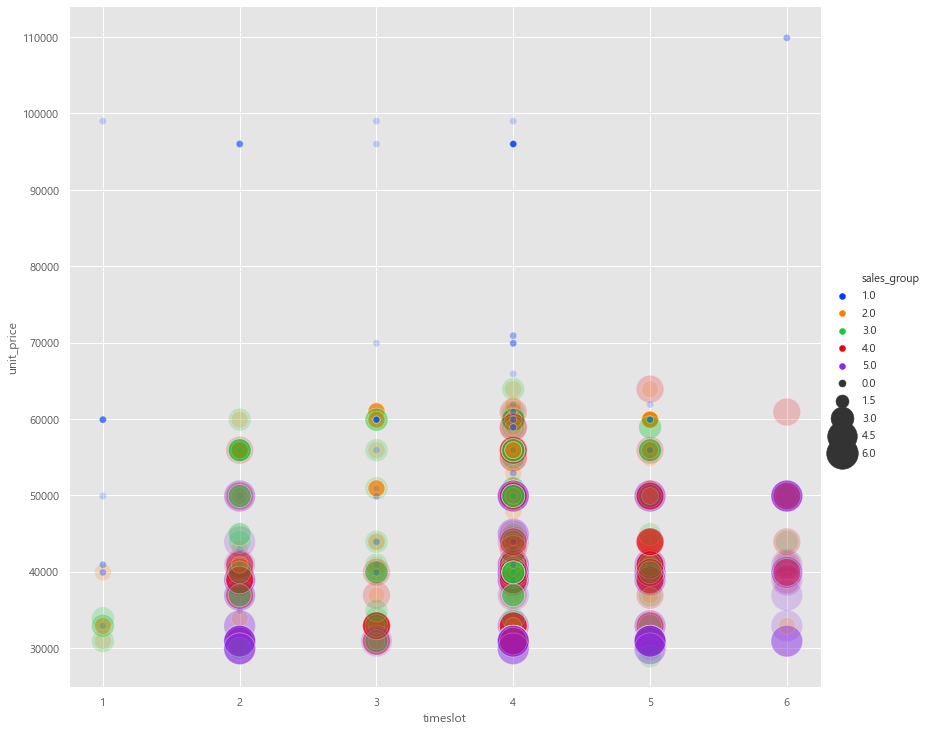

In [305]:
sns.relplot(x='timeslot',y='unit_price', palette='bright', size='sales_group', hue='sales_group', sizes=(50,1000), data=sum_df[(sum_df['p_group']=='농수축')&(sum_df['holiday']==0)], alpha=0.2, height=10.27, aspect=11.7/10.27)

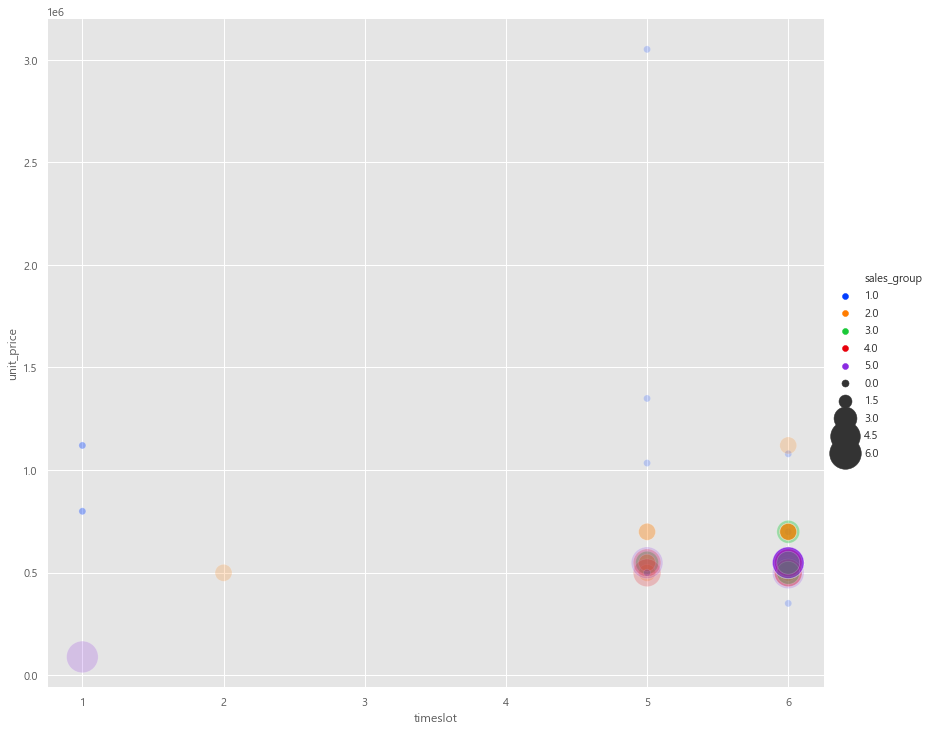

In [309]:
sns.relplot(x='timeslot',y='unit_price', palette='bright', size='sales_group', hue='sales_group', sizes=(50,1000), data=sum_df[(sum_df['p_group']=='가구')&(sum_df['holiday']==1)], alpha=0.2, height=10.27, aspect=11.7/10.27)

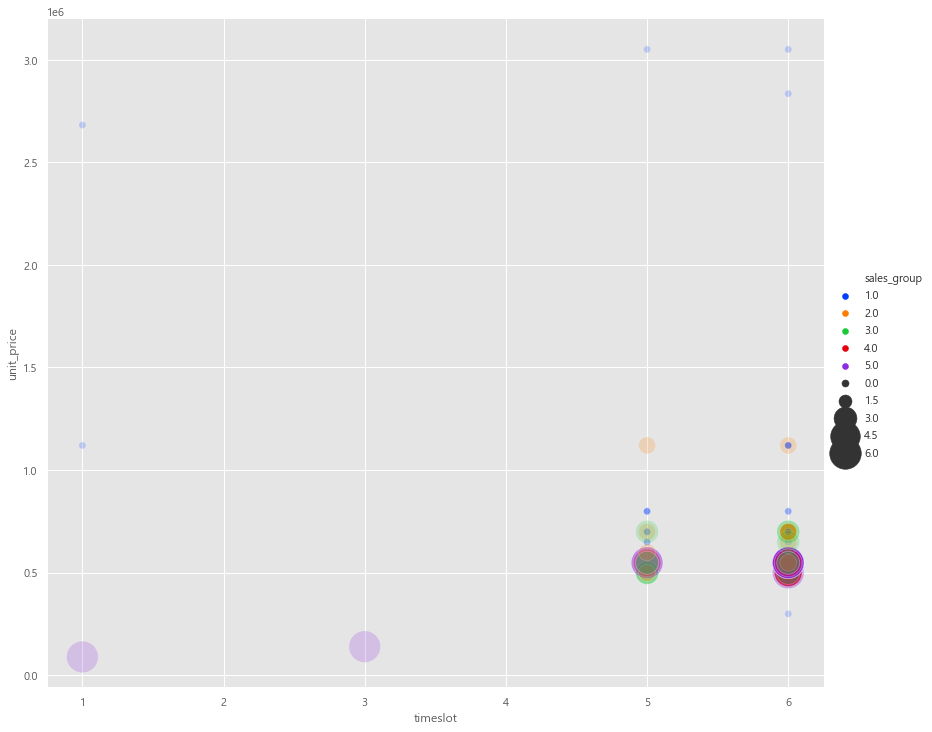

In [310]:
sns.relplot(x='timeslot',y='unit_price', palette='bright', size='sales_group', hue='sales_group', sizes=(50,1000), data=sum_df[(sum_df['p_group']=='가구')&(sum_df['holiday']==0)], alpha=0.2, height=10.27, aspect=11.7/10.27)

어떤 구간의 판매량 / 전체 판매량 > 0.5인 어떤 구간을 찾아서 그 구간 안의 sales_group이 1(최하)인 상품들을 추려낸다.

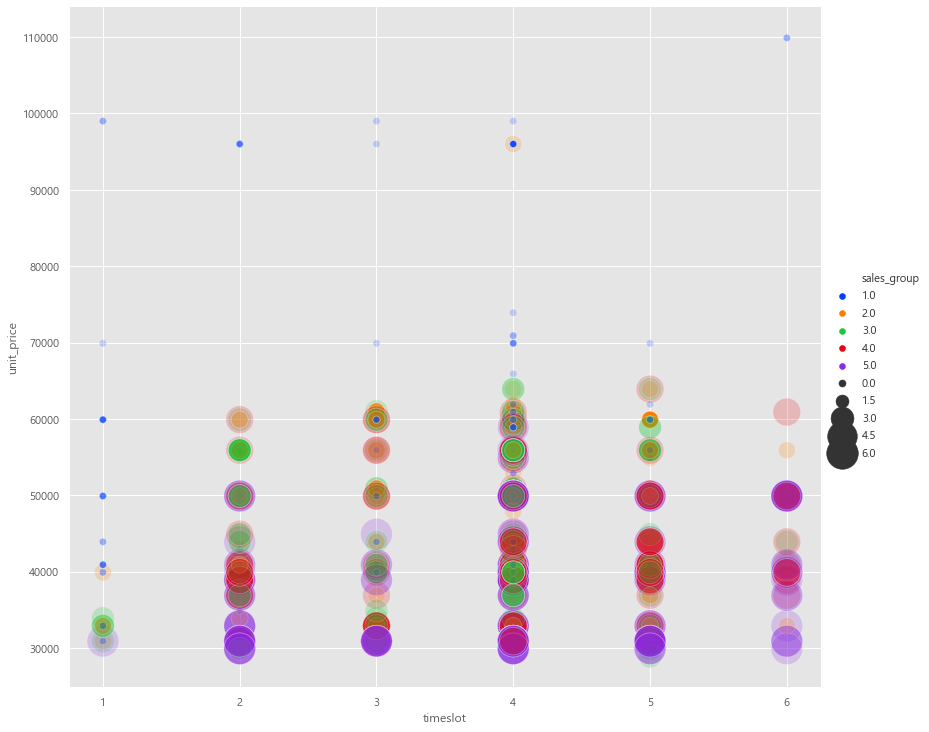

In [311]:
sns.relplot(x='timeslot',y='unit_price', palette='bright', size='sales_group', hue='sales_group', sizes=(50,1000), data=sum_df[sum_df['p_group']=='농수축'], alpha=0.2, height=10.27, aspect=11.7/10.27)

In [389]:
interested_group = ['농수축','건강기능','가구','침구']
group_solution_dict = {}


for group in interested_group:
    df = sum_df[sum_df['p_group']==group]
    solution_list = []
    df_total_sales = df.sales.sum()
    print('총 ',len(df.unit_price.unique()),'개의 unit_price')
    for idx, x in enumerate(sorted(df.unit_price.unique())):
        if idx % 10 == 0:
            print(idx, x)
        for y in sorted(df.unit_price.unique()):
            if x >= y:
                continue
            elif ((df[(df['unit_price'] >= x) & (df['unit_price'] <= y)].sales.sum() / df_total_sales) >= 0.49) &\
            ((df[(df['unit_price'] >= x) & (df['unit_price'] <= y)].sales.sum() / df_total_sales) <= 0.51):
                solution_list.append((x,y))
    group_solution_dict[group]=solution_list
group_solution_dict

총  34 개의 unit_price
0 28900
10 41900
20 55900
30 73900
총  26 개의 unit_price
0 39900
10 69900
20 129000
총  18 개의 unit_price
0 89000
10 799000
총  9 개의 unit_price
0 39900


{'농수축': [(40900, 59900), (40900, 60900), (40900, 61000)],
 '건강기능': [(42000, 69000),
  (50900, 69000),
  (54900, 69000),
  (54900, 69300),
  (59000, 69300)],
 '가구': [],
 '침구': []}

In [407]:
temp = df_split('농수축')[(df_split('농수축').unit_price >= 40900)&(df_split('농수축').unit_price <= 61000)&(df_split('농수축').sales_group == 1)]
temp.shape

(193, 27)

In [406]:
print(temp.p_name.unique())
print(len(temp.p_name.unique()))

['뽕셰프 이봉원 특갈비탕 12팩' '멋진밥상 흥양농협 햅쌀 20kg' '바다먹자 국내산 손질꽃게 7팩'
 '(a4)팽현숙의 순대 곱창 전골&볶음' '농협안심벌꿀 4병' '소들녘 더 맛있는 NEW  돼지왕구이 12팩'
 '청정수산 완도활전복 35미' '제주 한라봉2박스+천혜향1박스' '이봉원 정직한 안창살 + 갈비살구이'
 '전철우 소갈비살구이 10팩' '제주바다 7분 손질문어' '피시원 국내산 손질 대구 8팩 * 매운탕 양념 8팩'
 '청정수산 완도활전복 中사이즈 26미' '천연담아 명품다시팩 120포' '소들녘 소 갈비탕' '영산포숙성 홍어8팩+무침3통'
 '청정수산 완도활전복 大사이즈 20미' '국내산 손질갑오징어 9팩' '캘리포니아 카라카라 오렌지 8kg'
 '멋진밥상 흥양농협 쌀 20kg' '바다먹자 국내산 손질문어 9팩' '국내산 손질갑오징어 8팩' '영산포숙성 홍어 13팩'
 '이만기의 리얼국밥 3종 27팩' '속초명물 티각태각 부각 6종, 30봉' '[본죽] 그때 그 쇠고기 장조림 세트(총 13팩)'
 '피시원 국내산 손질꽃게 7팩' '최인선 셰프의 듬뿍 곤드레나물밥 16인분'
 '[맛있는 제주]손질 생선 3대세트(광어+갈치+고등어)' '국내산 손질 가자미 36미!' '[가격인하]전철우 소갈비살구이 10팩'
 '사용불가미리구운 자연산 바다장어 9팩' '궁중 해물철판 10팩' '유귀열의 The 귀한 꼬리곰탕 8팩'
 'AAB의 소곱창전골 800g x 8팩' '국내산 손질 병어 26미' '유귀열의 The 귀한 능이 누룽지삼계탕 8팩'
 '황토방 청도 감말랭이 30봉+무료체험1봉, 총 31봉' '유귀열의 The 귀한 한우 한판 12팩' '임성근의 녹용도가니탕 풀세트'
 '유귀열의 The 귀한 치마살' '소들녘 소 갈비탕 10팩' '이정섭의 비가린 배추김치 10kg'
 '영광 生 모시떡 130개(동부기피80개+검정깨50개)' '신세대 포기김치 11kg'
 '[농협안심벌꿀] 아카시아꿀 2병 + 야생화꿀 2병' '국내산 손질 갑오징어 9팩'
 '유귀열의 T

In [417]:
temp.DAY_NUM.value_counts()

5    39
1    33
7    30
4    28
2    24
3    22
6    17
Name: DAY_NUM, dtype: int64

In [418]:
temp.timeslot.value_counts()

4    74
5    67
3    25
1    19
2     8
7     0
6     0
Name: timeslot, dtype: int64